### Fourier Reconstruction of RR-Lyrae Templates

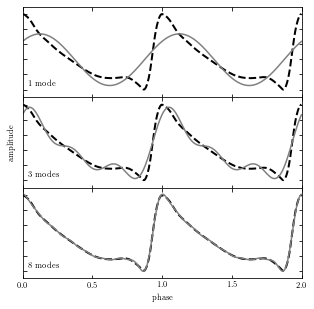

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.datasets import fetch_rrlyrae_templates

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Load the RR Lyare template
templates = fetch_rrlyrae_templates()
x, y = templates['115r'].T

# Plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0)

kvals = [1, 3, 8]
subplots = [311, 312, 313]

for (k, subplot) in zip(kvals, subplots):
    ax = fig.add_subplot(subplot)

    # Use FFT to fit a truncated Fourier series
    y_fft = np.fft.fft(y)
    y_fft[k+1:-k] = 0
    y_fit = np.fft.ifft(y_fft).real
    
    # plot the true value and the k-term reconstruction
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y, y]), '--k', lw=2)
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y_fit, y_fit]), color='gray')

    label = "%i mode" % k
    if k > 1:
        label += 's'

    ax.text(0.02, 0.1, label, ha='left', va='bottom',
            transform=ax.transAxes)

    if subplot == subplots[-1]:
        ax.set_xlabel('phase')
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    if subplot == subplots[1]:
        ax.set_ylabel('amplitude')
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlim(0, 2)
    ax.set_ylim(1.1, -0.1)

plt.show()

### Plot a Diagram explaining a Convolution

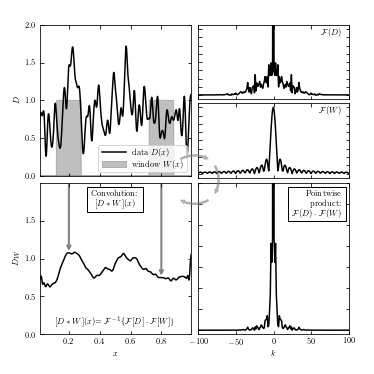

In [6]:
import numpy as np
from matplotlib import pyplot as plt

from scipy.signal import fftconvolve

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Generate random x, y with a given covariance length
np.random.seed(1)
x = np.linspace(0, 1, 500)
h = 0.01
C = np.exp(-0.5 * (x - x[:, None]) ** 2 / h ** 2)
y = 0.8 + 0.3 * np.random.multivariate_normal(np.zeros(len(x)), C)

# Define a normalized top-hat window function
w = np.zeros_like(x)
w[(x>0.12) & (x < 0.28)] = 1

# Perform the convolution
y_norm = np.convolve(np.ones_like(y), w, mode='full')
valid_indices = (y_norm != 0)
y_norm = y_norm[valid_indices]

y_w = np.convolve(y, w, mode = 'full')[valid_indices] / y_norm

# trick: convolve with x-coordinate to find the center of the window at each point

x_w = np.convolve(x, w, mode='full')[valid_indices] / y_norm

# Compute the Fourier transform of the signal and window
y_fft = np.fft.fft(y)
w_fft = np.fft.fft(w)

yw_fft = y_fft * w_fft
yw_final = np.fft.ifft(yw_fft)


# Set up the plots
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.09, bottom=0.09, right=0.95, top=0.95,
                    hspace=0.05, wspace=0.05)

#----------------------------------------
# plot the data and window function
ax = fig.add_subplot(221)
ax.plot(x, y, '-k', label=r'data $D(x)$')
ax.fill(x, w, color='gray', alpha=0.5,
        label=r'window $W(x)$')
ax.fill(x, w[::-1], color='gray', alpha=0.5)

ax.legend()
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('$D$')

ax.set_xlim(0.01, 0.99)
ax.set_ylim(0, 2.0)

#----------------------------------------
# plot the convolution
ax = fig.add_subplot(223)
ax.plot(x_w, y_w, '-k')

ax.text(0.5, 0.95, "Convolution:\n" + r"$[D \ast W](x)$",
        ha='center', va='top', transform=ax.transAxes,
        bbox=dict(fc='w', ec='k'), zorder=2)

ax.text(0.5, 0.05,
        (r'$[D \ast W](x)$' +
         r'$= \mathcal{F}^{-1}\{\mathcal{F}[D] \cdot \mathcal{F}[W]\}$'),
        ha='center', va='bottom', transform=ax.transAxes)

for x_loc in (0.2, 0.8):
    y_loc = y_w[x_w <= x_loc][-1]
    ax.annotate('', (x_loc, y_loc), (x_loc, 2.0), zorder=1,
                arrowprops=dict(arrowstyle='->', color='gray', lw=2))

ax.set_xlabel('$x$')
ax.set_ylabel('$D_W$')

ax.set_xlim(0.01, 0.99)
ax.set_ylim(0, 1.99)

#----------------------------------------
# plot the Fourier transforms
N = len(x)
k = - 0.5 * N + np.arange(N) * 1. / N / (x[1] - x[0])

ax = fig.add_subplot(422)
ax.plot(k, abs(np.fft.fftshift(y_fft)), '-k')

ax.text(0.95, 0.95, r'$\mathcal{F}(D)$',
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlim(-100, 100)
ax.set_ylim(-5, 85)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

ax = fig.add_subplot(424)
ax.plot(k, abs(np.fft.fftshift(w_fft)), '-k')

ax.text(0.95, 0.95,  r'$\mathcal{F}(W)$', ha='right', va='top',
        transform=ax.transAxes)

ax.set_xlim(-100, 100)
ax.set_ylim(-5, 85)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

#----------------------------------------
# plot the product of Fourier transforms
ax = fig.add_subplot(224)
ax.plot(k, abs(np.fft.fftshift(yw_fft)), '-k')

ax.text(0.95, 0.95, ('Pointwise\nproduct:\n' +
                     r'$\mathcal{F}(D) \cdot \mathcal{F}(W)$'),
        ha='right', va='top', transform=ax.transAxes,
        bbox=dict(fc='w', ec='k'), zorder=2)

ax.set_xlim(-100, 100)
ax.set_ylim(-100, 3500)

ax.set_xlabel('$k$')

ax.yaxis.set_major_formatter(plt.NullFormatter())

#------------------------------------------------------------
# Plot flow arrows
ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)

arrowprops = dict(arrowstyle="simple",
                  color="gray", alpha=0.5,
                  shrinkA=5, shrinkB=5,
                  patchA=None,
                  patchB=None,
                  connectionstyle="arc3,rad=-0.35")

ax.annotate('', [0.57, 0.57], [0.47, 0.57],
            arrowprops=arrowprops,
            transform=ax.transAxes)
ax.annotate('', [0.57, 0.47], [0.57, 0.57],
            arrowprops=arrowprops,
            transform=ax.transAxes)
ax.annotate('', [0.47, 0.47], [0.57, 0.47],
            arrowprops=arrowprops,
            transform=ax.transAxes)

plt.show()

### The effect of Sampling

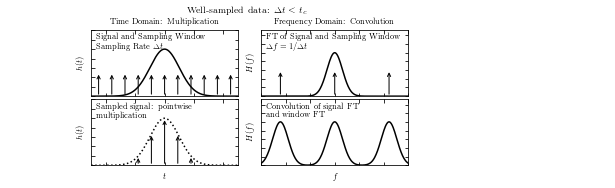

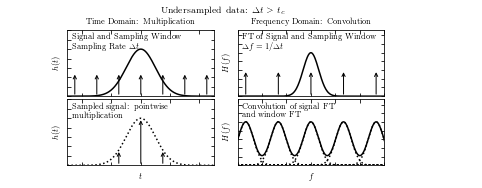

In [8]:
import numpy as np
from matplotlib import pyplot as plt

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

def gaussian(x, a=1.0):
    return np.exp(-0.5 * (x/a) ** 2)

def gaussian_FT(f, a=1.0):
    return np.sqrt(2 * np.pi * a ** 2) * np.exp(-2 * (np.pi * a * f) ** 2)

# Define our teams
a = 1.0
t = np.linspace(-5, 5, 1000)
h = gaussian(t, a)

f = np.linspace(-5, 5, 1000)
H = gaussian_FT(f, a)

# Two plots: one well-sampled, one over-sampled
N = 12

for dt in (0.9, 1.5):
    # define time-space sampling
    t_sample = dt * (np.arange(N) - N / 2)
    h_sample = gaussian(t_sample, a)
    
    # Fourier transform of time-space sampling
    df = 1. / dt
    f_sample = df * (np.arange(N) - N / 2)
    
    # Plot the results
    fig = plt.figure(figsize=(5, 2.5))
    fig.subplots_adjust(left=0.07, right=0.95, wspace=0.16,
                        bottom=0.1, top=0.85, hspace=0.05)

    # First plot: sampled time-series
    ax = fig.add_subplot(221)
    ax.plot(t, h, '-k')

    for ts in t_sample:
        ax.annotate('', (ts, 0.5), (ts, 0), ha='center', va='center',
                    arrowprops=dict(arrowstyle='->'))
    ax.text(0.03, 0.95,
            ("Signal and Sampling Window\n" +
             r"Sampling Rate $\Delta t$"),
            ha='left', va='top', transform=ax.transAxes)
    ax.set_ylabel('$h(t)$')
    ax.set_xlim(-5, 5)
    ax.set_ylim(0, 1.4)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_title('Time Domain: Multiplication')

    # second plot: frequency space
    ax = fig.add_subplot(222)
    ax.plot(f, H, '-k')
    for fs in f_sample:
        ax.annotate('', (fs, 1.5), (fs, 0), ha='center', va='center',
                    arrowprops=dict(arrowstyle='->'))
    ax.text(0.03, 0.95,
            ("FT of Signal and Sampling Window\n" +
             r"$\Delta f = 1 / \Delta t$"),
            ha='left', va='top', transform=ax.transAxes)
    ax.set_ylabel('$H(f)$')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(0, 3.8)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_title('Frequency Domain: Convolution')

    # third plot: windowed function
    ax = fig.add_subplot(223)
    for (ts, hs) in zip(t_sample, h_sample):
        if hs < 0.1:
            continue
        ax.annotate('', (ts, hs), (ts, 0), ha='center', va='center',
                    arrowprops=dict(arrowstyle='->'))
    ax.plot(t, h, ':k')
    ax.text(0.03, 0.95, "Sampled signal: pointwise\nmultiplication",
            ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$h(t)$')
    ax.set_xlim(-5, 5)
    ax.set_ylim(0, 1.4)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    # fourth plot: convolved PSD
    ax = fig.add_subplot(224)
    window = np.array([gaussian_FT(f - fs, a) for fs in f_sample])
    ax.plot(f, window.sum(0), '-k')
    if dt > 1:
        ax.plot(f, window.T, ':k')
    ax.text(0.03, 0.95, "Convolution of signal FT\nand window FT",
            ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$f$')
    ax.set_ylabel('$H(f)$')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(0, 3.8)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    if dt > 1:
        fig.suptitle(r"Undersampled data: $\Delta t > t_c$")
    else:
        fig.suptitle(r"Well-sampled data: $\Delta t < t_c$")

plt.show()

### The effect of Sampling : 2

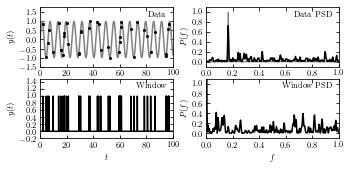

In [9]:
import numpy as np
from matplotlib import pyplot as plt

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Generate the data
Nbins = 2 ** 15
Nobs = 40
f = lambda t: np.sin(np.pi * t / 3)

t = np.linspace(-100, 200, Nbins)
dt = t[1] - t[0]
y = f(t)

# select observations
np.random.seed(42)
t_obs = 100 * np.random.random(40)

D = abs(t_obs[:, np.newaxis] - t)
i = np.argmin(D, 1)

t_obs = t[i]
y_obs = y[i]
window = np.zeros(Nbins)
window[i] = 1

# Compute PSDs
Nfreq = int(Nbins / 2)

dt = t[1] - t[0]
df = 1. / (Nbins * dt)
f = df * np.arange(Nfreq)

PSD_window = abs(np.fft.fft(window)[:Nfreq]) ** 2
PSD_y = abs(np.fft.fft(y)[:Nfreq]) ** 2
PSD_obs = abs(np.fft.fft(y * window)[:Nfreq]) ** 2

# scale PSDs for plotting
PSD_window /= 500
PSD_y  /= PSD_y.max()
PSD_obs /= 500

# Prepare the figures
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(bottom=0.15, hspace=0.2, wspace=0.25,
                    left=0.12, right=0.95)

# First panel: data vs time
ax = fig.add_subplot(221)
ax.plot(t, y, '-', c='gray')
ax.plot(t_obs, y_obs, '.k', ms=4)
ax.text(0.95, 0.93, "Data", ha='right', va='top', transform=ax.transAxes)
ax.set_ylabel('$y(t)$')
ax.set_xlim(0, 100)
ax.set_ylim(-1.5, 1.8)

# Second panel: PSD of data
ax = fig.add_subplot(222)
ax.fill(f, PSD_y, fc='gray', ec='gray')
ax.plot(f, PSD_obs, '-', c='black')
ax.text(0.95, 0.93, "Data PSD", ha='right', va='top', transform=ax.transAxes)
ax.set_ylabel('$P(f)$')
ax.set_xlim(0, 1.0)
ax.set_ylim(-0.1, 1.1)

# Third panel: window vs time
ax = fig.add_subplot(223)
ax.plot(t, window, '-', c='black')
ax.text(0.95, 0.93, "Window", ha='right', va='top', transform=ax.transAxes)
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')
ax.set_xlim(0, 100)
ax.set_ylim(-0.2, 1.5)

# Fourth panel: PSD of window
ax = fig.add_subplot(224)
ax.plot(f, PSD_window, '-', c='black')
ax.text(0.95, 0.93, "Window PSD", ha='right', va='top', transform=ax.transAxes)
ax.set_xlabel('$f$')
ax.set_ylabel('$P(f)$')
ax.set_xlim(0, 1.0)
ax.set_ylim(-0.1, 1.1)

plt.show()


### Fast Fourier Transform Example

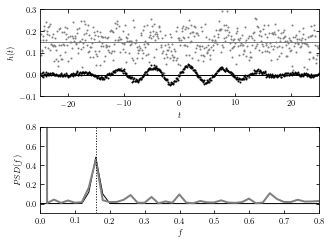

In [12]:
import numpy as np
from matplotlib import pyplot as plt

from scipy.fftpack import fft
from scipy.stats import norm

from astroML.fourier import PSD_continuous

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Draw the data
np.random.seed(1)

tj = np.linspace(-25, 25, 512)
hj = np.sin(tj)
hj *= norm(0, 10).pdf(tj)

# Plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(hspace=0.35)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

offsets = (0, 0.15)
colors = ('black', 'gray')
linewidths = (1, 2)
errors = (0.005, 0.05)

for (offset, color, error, linewidth) in zip(offsets, colors,
                                            errors, linewidths):
    # Compute the PSD
    err = np.random.normal(0, error, size = hj.shape)
    hj_N = hj + err + offset
    fk, PSD = PSD_continuous(tj, hj_N)
    
    # Plot the data and PSD
    ax1.scatter(tj, hj_N, s=4, c=color, lw=0)
    ax1.plot(tj, 0 * tj + offset, '-', c=color, lw=1)
    ax2.plot(fk, PSD, '-', c=color, lw=linewidth)
    
# Vertical line marking the expected peak location
ax2.plot([0.5 / np.pi, 0.5 / np.pi], [-0.1, 1], ':k', lw=1)

ax1.set_xlim(-25, 25)
ax1.set_ylim(-0.1, 0.3001)

ax1.set_xlabel('$t$')
ax1.set_ylabel('$h(t)$')

ax1.yaxis.set_major_locator(plt.MultipleLocator(0.1))

ax2.set_xlim(0, 0.8)
ax2.set_ylim(-0.101, 0.801)

ax2.set_xlabel('$f$')
ax2.set_ylabel('$PSD(f)$')

plt.show()

### FFT LIGO power spectrum

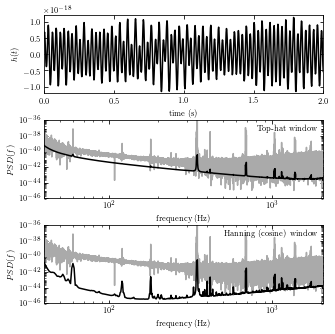

In [17]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import fftpack
from matplotlib import mlab

from astroML.datasets import fetch_LIGO_large

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Fetch the LIGO hanford data
data, dt = fetch_LIGO_large()

# subset of the data to plot
t0 = 646
T = 2
tplot = dt * np.arange(T * 4096)
dplot = data[4096 * t0: 4096 * (t0 + T)]

tplot = tplot[::10]
dplot = dplot[::10]

fmin = 40
fmax = 2060

# Compute PSD using simple FFT (PSD:Particle-size-distribution)
N = len(data)
df = 1. / (N * dt)
PSD = abs(dt * fftpack.fft(data)[:N // 2]) ** 2
f = df * np.arange(N / 2)

cutoff = ((f >= fmin) & (f <= fmax))
f = f[cutoff]
PSD = PSD[cutoff]
f = f[::100]
PSD = PSD[::100]

# Compute PSD using Welch;s method
PSDW1, fW1 = mlab.psd(data, NFFT=4096, Fs=1. / dt, 
                     window = mlab.window_none, noverlap=2048)

dfW1 = fW1[1] - fW1[0]

cutoff = (fW1 >= fmin) & (fW1 <= fmax)
fW1 = fW1[cutoff]
PSDW1 = PSDW1[cutoff]

# Compute PSD using Welch's methd -- hanning window function
PSDW2, fW2 = mlab.psd(data, NFFT=4096, Fs=1./dt,
                     window = mlab.window_hanning, noverlap=2048)

dfW2 = fW2[1] - fW2[0]

cutoff = (fW2 >= fmin) & (fW2 <= fmax)
fW2 = fW2[cutoff]
PSDW2 = PSDW2[cutoff]

# Plot the data
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.1, top=0.9, hspace=0.35)

# top panel: time series
ax = fig.add_subplot(311)
ax.plot(tplot, dplot, '-k')
ax.set_xlabel('time (s)')
ax.set_ylabel('$h(t)$')

ax.set_ylim(-1.2E-18, 1.2E-18)

# middle panel: non-windowed filter
ax = fig.add_subplot(312)
ax.loglog(f, PSD, '-', c='#AAAAAA')
ax.loglog(fW1, PSDW1, '-k')
ax.text(0.98, 0.95, "Top-hat window",
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel(r'$PSD(f)$')

ax.set_xlim(40, 2060)
ax.set_ylim(1E-46, 1E-36)
ax.yaxis.set_major_locator(plt.LogLocator(base=100))

# bottom panel: hanning window
ax = fig.add_subplot(313)
ax.loglog(f, PSD, '-', c='#AAAAAA')
ax.loglog(fW2, PSDW2, '-k')
ax.text(0.98, 0.95, "Hanning (cosine) window",
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel(r'$PSD(f)$')

ax.set_xlim(40, 2060)
ax.set_ylim(1E-46, 1E-36)
ax.yaxis.set_major_locator(plt.LogLocator(base=100))

plt.show()

### Wavelet transform of Gaussian Noise

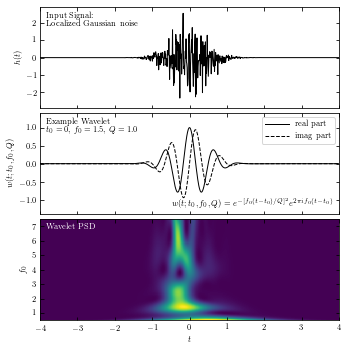

In [22]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.fourier import\
    FT_continuous, IFT_continuous, sinegauss, sinegauss_FT, wavelet_PSD

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Sample the function: localized noise
np.random.seed(0)

N = 1024
t = np.linspace(-5, 5, N)
x = np.ones(len(t))

h = np.random.normal(0, 1, len(t))
h *= np.exp(-0.5 * (t / 0.5) ** 2)

# Compute an example wavelet
W = sinegauss(t, 0, 1.5, Q=1.0)

# Compute the wavelet PSD
f0 = np.linspace(0.5, 7.5, 100)
wPSD = wavelet_PSD(t, h, f0, Q=1.0)

# Plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0.05, left=0.12, right=0.95, bottom=0.08, top=0.95)

# First panel: the signal
ax = fig.add_subplot(311)
ax.plot(t, h, '-k', lw=1)
ax.text(0.02, 0.95, ("Input Signal:\n"
                     "Localized Gaussian noise"),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlim(-4, 4)
ax.set_ylim(-2.9, 2.9)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('$h(t)$')

# Second panel: an example wavelet
ax = fig.add_subplot(312)
ax.plot(t, W.real, '-k', label='real part', lw=1)
ax.plot(t, W.imag, '--k', label='imag part', lw=1)

ax.text(0.02, 0.95, ("Example Wavelet\n"
                     "$t_0 = 0$, $f_0=1.5$, $Q=1.0$"),
        ha='left', va='top', transform=ax.transAxes)
ax.text(0.98, 0.05,
        (r"$w(t; t_0, f_0, Q) = e^{-[f_0 (t - t_0) / Q]^2}"
         "e^{2 \pi i f_0 (t - t_0)}$"),
        ha='right', va='bottom', transform=ax.transAxes)

ax.legend(loc=1)

ax.set_xlim(-4, 4)
ax.set_ylim(-1.4, 1.4)
ax.set_ylabel('$w(t; t_0, f_0, Q)$')
ax.xaxis.set_major_formatter(plt.NullFormatter())

# Third panel: the spectrogram
ax = plt.subplot(313)
ax.imshow(wPSD, origin='lower', aspect='auto',
          extent=[t[0], t[-1], f0[0], f0[-1]])

ax.text(0.02, 0.95, ("Wavelet PSD"), color='w',
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlim(-4, 4)
ax.set_ylim(0.5, 7.5)

ax.set_xlabel('$t$')
ax.set_ylabel('$f_0$')

plt.show()


### Wavelet transform of a Noisy Spike

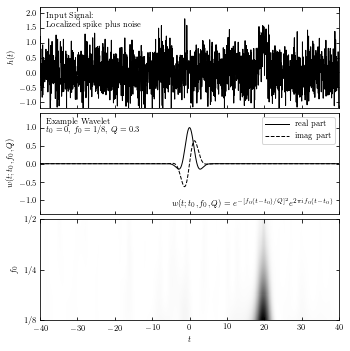

In [23]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.fourier import FT_continuous, IFT_continuous

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

def wavelet(t, t0, f0, Q):
    return (np.exp(-(f0 / Q * (t - t0)) ** 2)
           * np.exp(2j * np.pi * f0 * (t-t0)))

def wavelet_FT(f, t0, f0, Q):
    return (np.sqrt(np.pi) * Q / f0
           * np.exp(-2j * np.pi * f * t0)
           * np.exp(-(np.pi * (f-f0) * Q / f0) ** 2))

def check_funcs(t0=1, f0=2, Q=3):
    t = np.linspace(-5, 5, 10000)
    h = wavelet(t, t0, f0, Q)
    
    f, H = FT_continuous(t, h)
    assert np.allclose(H, wavelet_Ft(f, t0, f0, Q))
    
# Create the simulated dataset
np.random.seed(5)

t = np.linspace(-40, 40, 2001)[:-1]
h = np.exp(-0.5 * ((t - 20.) / 1.0) ** 2)
hN = h + np.random.normal(0, 0.5, size = h.shape)

# Compute the convolution via the continuous Fourier transform
Q = 0.3
f0 = 2 ** np.linspace(-3, -1, 100)

f, H = FT_continuous(t, hN)
W = np.conj(wavelet_FT(f, 0, f0[:, None], Q))
t, HW = IFT_continuous(f, H * W)

# Plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0.05, left=0.12, right=0.95, bottom=0.08, top=0.95)

# First panel: the signal
ax = fig.add_subplot(311)
ax.plot(t, hN, '-k', lw=1)

ax.text(0.02, 0.95, ("Input Signal:\n"
                     "Localized spike plus noise"),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlim(-40, 40)
ax.set_ylim(-1.2, 2.2)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('$h(t)$')

# Second panel: the wavelet
ax = fig.add_subplot(312)
W = wavelet(t, 0, 0.125, Q)
ax.plot(t, W.real, '-k', label='real part', lw=1)
ax.plot(t, W.imag, '--k', label='imag part', lw=1)

ax.legend(loc=1)
ax.text(0.02, 0.95, ("Example Wavelet\n"
                     "$t_0 = 0$, $f_0=1/8$, $Q=0.3$"),
        ha='left', va='top', transform=ax.transAxes)
ax.text(0.98, 0.05,
        (r"$w(t; t_0, f_0, Q) = e^{-[f_0 (t - t_0) / Q]^2}"
         "e^{2 \pi i f_0 (t - t_0)}$"),
        ha='right', va='bottom', transform=ax.transAxes)

ax.set_xlim(-40, 40)
ax.set_ylim(-1.4, 1.4)
ax.set_ylabel('$w(t; t_0, f_0, Q)$')
ax.xaxis.set_major_formatter(plt.NullFormatter())

# Third panel: the spectrogram
ax = fig.add_subplot(313)
ax.imshow(abs(HW) ** 2, origin='lower', aspect='auto', cmap=plt.cm.binary,
          extent=[t[0], t[-1], np.log2(f0)[0], np.log2(f0)[-1]])
ax.set_xlim(-40, 40)

ax.text(0.02, 0.95, ("Wavelet PSD"), color='w',
        ha='left', va='top', transform=ax.transAxes)

ax.set_ylim(np.log2(f0)[0], np.log2(f0)[-1])
ax.set_xlabel('$t$')
ax.set_ylabel('$f_0$')

ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, *args: ("1/%i"
                                                                 % (2 ** -x))))
plt.show()


### Examples of Wavelets

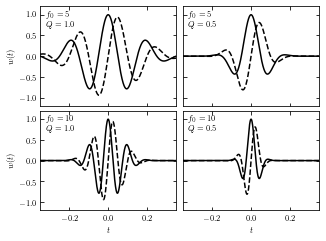

In [25]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.fourier import FT_continuous, IFT_continuous, sinegauss

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Set up the wavelets
t0 = 0
t = np.linspace(-0.4, 0.4, 10000)
f0 = np.array([5, 5, 10, 10])
Q = np.array([1, 0.5, 1, 0.5])

# Compute wavelents all at once
W = sinegauss(t, t0, f0[:, None], Q[:, None])

# Plot the wavelets
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# in each panel, plot and label a different wavelet
for i in range(4):
    ax = fig.add_subplot(221 + i)
    ax.plot(t, W[i].real, '-k')
    ax.plot(t, W[i].imag, '--k')

    ax.text(0.04, 0.95, "$f_0 = %i$\n$Q = %.1f$" % (f0[i], Q[i]),
            ha='left', va='top', transform=ax.transAxes)

    ax.set_ylim(-1.2, 1.2)
    ax.set_xlim(-0.35, 0.35)

    ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))

    if i in (0, 1):
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_xlabel('$t$')

    if i in (1, 3):
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_ylabel('$w(t)$')

plt.show()

### Wiener Filter

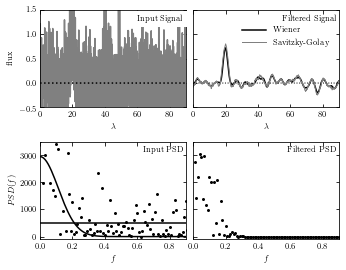

In [27]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import optimize, fftpack
from astroML.filters import savitzky_golay, wiener_filter

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Create the noisy data
np.random.seed(5)
N = 2000
dt = 0.05

t = dt * np.arange(N)
h = np.exp(-0.5 * ((t - 20.)/ 1.0) ** 2)
hN = h + np.random.normal(0, 0.5, size = h.shape)

Df = 1. / N / df
f = fftpack.ifftshift(Df * (np.arange(N) - N / 2))
HN = fftpack.fft(hN)

# Set up the Wiener filter:
h_smooth, PSD, P_S, P_N, Phi = wiener_filter(t, hN, return_PSDs = True)

# Use the Savitzky-Golay filter to filter the values
h_sg = savitzky_golay(hN, window_size=201, order = 4, use_fft = False)

# Plot the results
N = len(t)
Df = 1. / N / (t[1] - t[0])
f = fftpack.ifftshift(Df * (np.arange(N) - N / 2))
HN = fftpack.fft(hN)

fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(wspace=0.05, hspace=0.35,
                    bottom=0.1, top=0.95,
                    left=0.12, right=0.95)

# First plot: noisy signal
ax = fig.add_subplot(221)
ax.plot(t, hN, '-', c='gray')
ax.plot(t, np.zeros_like(t), ':k')
ax.text(0.98, 0.95, "Input Signal", ha='right', va='top',
        transform=ax.transAxes, bbox=dict(fc='w', ec='none'))

ax.set_xlim(0, 90)
ax.set_ylim(-0.5, 1.5)

ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('flux')

# Second plot: filtered signal
ax = plt.subplot(222)
ax.plot(t, np.zeros_like(t), ':k', lw=1)
ax.plot(t, h_smooth, '-k', lw=1.5, label='Wiener')
ax.plot(t, h_sg, '-', c='gray', lw=1, label='Savitzky-Golay')

ax.text(0.98, 0.95, "Filtered Signal", ha='right', va='top',
        transform=ax.transAxes)
ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.9), frameon=False)

ax.set_xlim(0, 90)
ax.set_ylim(-0.5, 1.5)

ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.set_xlabel(r'$\lambda$')

# Third plot: Input PSD
ax = fig.add_subplot(223)
ax.scatter(f[:N // 2], PSD[:N // 2], s=9, c='k', lw=0)
ax.plot(f[:N // 2], P_S[:N // 2], '-k')
ax.plot(f[:N // 2], P_N[:N // 2], '-k')

ax.text(0.98, 0.95, "Input PSD", ha='right', va='top',
        transform=ax.transAxes)

ax.set_ylim(-100, 3500)
ax.set_xlim(0, 0.9)

ax.yaxis.set_major_locator(plt.MultipleLocator(1000))
ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.set_xlabel('$f$')
ax.set_ylabel('$PSD(f)$')

# Fourth plot: Filtered PSD
ax = fig.add_subplot(224)
filtered_PSD = (Phi * abs(HN)) ** 2
ax.scatter(f[:N // 2], filtered_PSD[:N // 2], s=9, c='k', lw=0)

ax.text(0.98, 0.95, "Filtered PSD", ha='right', va='top',
        transform=ax.transAxes)

ax.set_ylim(-100, 3500)
ax.set_xlim(0, 0.9)

ax.yaxis.set_major_locator(plt.MultipleLocator(1000))
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.set_xlabel('$f$')

plt.show()

### Wiener Filter / kernel smoothing connection

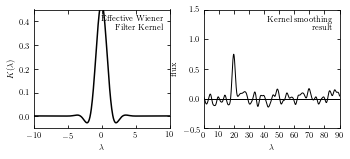

In [30]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import optimize, fftpack, interpolate
from astroML.fourier import IFT_continuous
from astroML.filters import wiener_filter

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# sample the same data as the previous Wiener filter figure
np.random.seed(5)
t = np.linspace(0, 100, 2001)[:-1]
h = np.exp(-0.5 * ((t - 20.) / 1.0) ** 2)
hN = h + np.random.normal(0, 0.5, size = h.shape)

# compute the PSD
N = len(t)
t = np.linspace(0, 100, 2001)[:-1]
h = np.exp(-0.5 * ((t - 20.) / 1.0) ** 2)
hN = h + np.random.normal(0, 0.5, size = h.shape)

# compute the PSD
N = len(t)
Df = 1. / N / (t[1] - t[0])
f = fftpack.ifftshift(Df * (np.arange(N) - N / 2))

h_weiner, PSD, P_S, P_N, Phi = wiener_filter(t, hN, return_PSDs = True)

# Inverse fourier transform Phi to find the effective kernerl
t_plot, kernel = IFT_continuous(f, Phi)

# Perform kernel smoothing on the data.
kernel_func = interpolate.interp1d(t_plot, kernel.real)

t_eval = np.linspace(0, 90, 1000)
t_KDE = t_eval[:, np.newaxis] - t
t_KDE[t_KDE < t_plot[0]] = t_plot[0]
t_KDE[t_KDE > t_plot[-1]] = t_plot[-1]
F = kernel_func(t_KDE)

h_smooth = np.dot(F, hN) / np.sum(F, 1)

# Plot the results
fig = plt.figure(figsize=(5, 2.2))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.15, top=0.9)

# First plot: the equivalent Kernel to the WF
ax = fig.add_subplot(121)
ax.plot(t_plot, kernel.real, '-k')
ax.text(0.95, 0.95, "Effective Wiener\nFilter Kernel",
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlim(-10, 10)
ax.set_ylim(-0.05, 0.45)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$K(\lambda)$')

# Second axes: Kernel smoothed results
ax = fig.add_subplot(122)
ax.plot(t_eval, h_smooth, '-k', lw=1)
ax.plot(t_eval, 0 * t_eval, '-k', lw=1)
ax.text(0.95, 0.95, "Kernel smoothing\nresult",
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlim(0, 90)
ax.set_ylim(-0.5, 1.5)

ax.set_xlabel('$\lambda$')
ax.set_ylabel('flux')

plt.show()


### Minimum component fitting procedure

/home/lokesh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


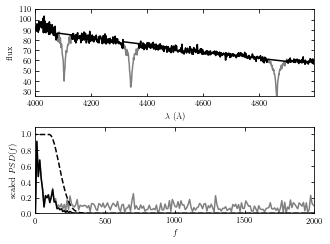

In [35]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import fftpack

from astroML.fourier import PSD_continuous
from astroML.datasets import fetch_sdss_spectrum

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Fetch the spectrum from SDSS database & pre-process
plate = 659
mjd = 52199
fiber = 381

data = fetch_sdss_spectrum(plate, mjd, fiber)

lam = data.wavelength()
spec = data.spectrum

# wavelengths are logarithimcally spaced
loglam = np.log10(lam)

flag = (lam > 4000) & (lam < 5000)
lam  = lam[flag]
loglam = loglam[flag]
spec = spec[flag]

lam = lam[:-1]
loglam = loglam[:-1]
spec = spec[:-1]

# First step: mask-out significant features
feature_mask = (((lam > 4080) & (lam < 4130)) |
                ((lam > 4315) & (lam < 4370)) |
                ((lam > 4830) & (lam < 4900)))


# Second step: fit a line to the unmasked portion of the spectrum
XX = loglam[:, None] ** np.arange(2)
beta = np.linalg.lstsq(XX[~feature_mask], spec[~feature_mask])[0]

spec_fit = np.dot(XX, beta)
spec_patched = spec - spec_fit
spec_patched[feature_mask]  = 0

# Third step: Fourier transform the patched spectrum
N = len(loglam)
df = 1. / N / (loglam[1] - loglam[0])
f = fftpack.ifftshift(df * (np.arange(N) - N / 2.))
spec_patched_FT = fftpack.fft(spec_patched)

# Fourth step: Low-pass filter on the tranform
filt = np.exp(- (0.01 * (abs(f) - 100.)) ** 2)
filt[abs(f) < 100] = 1

spec_filt_FT = spec_patched_FT * filt

# Fifth step : inverse Fourier transform and add back the fit
spec_filt = fftpack.ifft(spec_filt_FT)
spec_filt += spec_fit

# Plot results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(hspace=0.35)

ax = fig.add_subplot(211)
ax.plot(lam, spec, '-', c='gray')
ax.plot(lam, spec_patched + spec_fit, '-k')

ax.set_ylim(25, 110)

ax.set_xlabel(r'$\lambda\ {\rm(\AA)}$')
ax.set_ylabel('flux')

ax = fig.add_subplot(212)
factor = 15 * (loglam[1] - loglam[0])
ax.plot(fftpack.fftshift(f),
        factor * fftpack.fftshift(abs(spec_patched_FT) ** 1),
        '-', c='gray', label='masked/shifted spectrum')
ax.plot(fftpack.fftshift(f),
        factor * fftpack.fftshift(abs(spec_filt_FT) ** 1),
        '-k', label='filtered spectrum')
ax.plot(fftpack.fftshift(f),
        fftpack.fftshift(filt), '--k', label='filter')

ax.set_xlim(0, 2000)
ax.set_ylim(0, 1.1)

ax.set_xlabel('$f$')
ax.set_ylabel('scaled $PSD(f)$')

plt.show()

### Example of Minimum Component Filtering

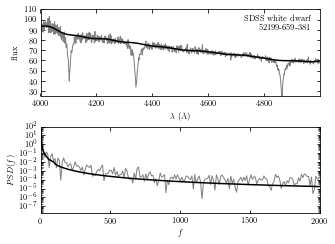

In [36]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.fourier import PSD_continuous
from astroML.datasets import fetch_sdss_spectrum
from astroML.filters import min_component_filter

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Fetch the spectrum from SDSS database & pre-process
plate = 659
mjd = 52199
fiber = 381

data = fetch_sdss_spectrum(plate, mjd, fiber)

lam = data.wavelength()
spec = data.spectrum

# wavelengths are logorithmically spaced: we' ll work in log(lam)
loglam = np.log10(lam)

flag = (lam > 4000) & (lam < 5000)
lam = lam[flag]
loglam = loglam[flag]
spec = spec[flag]

lam = lam[:-1]
loglam = loglam[:-1]
spec = spec[:-1]

# Mask-out significant features and compute filtered version
# Mask-out significant features and compute filtered version
feature_mask = (((lam > 4080) & (lam < 4130)) |
                ((lam > 4315) & (lam < 4370)) |
                ((lam > 4830) & (lam < 4900)))

spec_filtered = min_component_filter(loglam, spec, feature_mask , fcut=100)

# Compute PSD of filtered and unfiltered versions
f, spec_filt_PSD = PSD_continuous(loglam, spec_filtered)
f, spec_PSD = PSD_continuous(loglam, spec)

# Plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(hspace=0.35)

# Top panel: plot noisy and smoothed spectrum
ax = fig.add_subplot(211)
ax.plot(lam, spec, '-', c='gray', lw=1)
ax.plot(lam, spec_filtered, '-k')

ax.text(0.97, 0.93, "SDSS white dwarf\n %i-%i-%i" % (mjd, plate, fiber),
        ha='right', va='top', transform=ax.transAxes)

ax.set_ylim(25, 110)

ax.set_xlabel(r'$\lambda\ {\rm (\AA)}$')
ax.set_ylabel('flux')

# Bottom panel: plot noisy and smoothed PSD
ax = fig.add_subplot(212, yscale='log')
ax.plot(f, spec_PSD, '-', c='gray', lw=1)
ax.plot(f, spec_filt_PSD, '-k')

ax.set_xlabel(r'$f$')
ax.set_ylabel('$PSD(f)$')
ax.set_xlim(0, 2000)

plt.show()

### The effect of Sampling

        Use astropy.stats.LombScargle instead. [__main__]
        Use astropy.stats.LombScargle instead. [__main__]
        Use astropy.stats.LombScargle instead. [__main__]
        Use astropy.stats.LombScargle instead. [__main__]


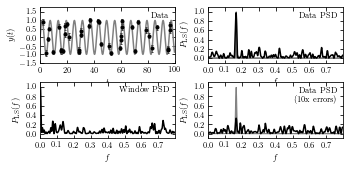

In [40]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from astroML.time_series import lomb_scargle


if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
matplotlib.rcParams['axes.xmargin'] = 0


# Generate the data
np.random.seed(42)
t_obs = 100 * np.random.random(40)  # 40 observations in 100 days
y_obs1 = np.sin(np.pi * t_obs / 3)
dy1 = 0.1 + 0.1 * np.random.random(y_obs1.shape)
y_obs1 += np.random.normal(0, dy1)

y_obs2 = np.sin(np.pi * t_obs / 3)
dy2 = 10 * dy1
y_obs2 = y_obs2 + np.random.normal(dy2)

y_window = np.ones_like(y_obs1)

t = np.linspace(0, 100, 10000)
y = np.sin(np.pi * t/3)

# Compute the periodogram
omega = np.linspace(0, 5, 1001)[1:]
P_obs1 = lomb_scargle(t_obs, y_obs1, dy1, omega)
P_obs2 = lomb_scargle(t_obs, y_obs2, dy2, omega)
P_window = lomb_scargle(t_obs, y_window, 1, omega,
                       generalized=False, subtract_mean = False)
P_true = lomb_scargle(t, y, 1, omega)

omega /= 2 * np.pi

# Prepare the figures
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(bottom=0.15, hspace=0.35, wspace=0.25,
                    left=0.11, right=0.95)

ax = fig.add_subplot(221)
ax.plot(t, y, '-', c='gray')
ax.errorbar(t_obs, y_obs1, dy1, fmt='.k', capsize=1, ecolor='#444444')
ax.text(0.96, 0.92, "Data", ha='right', va='top', transform=ax.transAxes)
ax.set_ylim(-1.5, 1.8)
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')

ax = fig.add_subplot(223)
ax.plot(omega, P_window, '-', c='black')
ax.text(0.96, 0.92, "Window PSD", ha='right', va='top', transform=ax.transAxes)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('$f$')
ax.set_ylabel(r'$P_{\rm LS}(f)$')

ax = fig.add_subplot(222)
ax.fill(omega, P_true, fc='gray', ec='gray')
ax.plot(omega, P_obs1, '-', c='black')
ax.text(0.96, 0.92, "Data PSD", ha='right', va='top', transform=ax.transAxes)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('$f$')
ax.set_ylabel(r'$P_{\rm LS}(f)$')

ax = fig.add_subplot(224)
ax.fill(omega, P_true, fc='gray', ec='gray')
ax.plot(omega, P_obs2, '-', c='black')
ax.text(0.96, 0.92, "Data PSD\n(10x errors)",
        ha='right', va='top', transform=ax.transAxes)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('$f$')
ax.set_ylabel(r'$P_{\rm LS}(f)$')

plt.show()

In [ ]:

from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

import pymc3 as pm

from astroML.plotting.mcmc import plot_mcmc
from astroML.utils.decorators import pickle_results

# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# ------------------------------------------------------------
# Create  some  data
np.random.seed(1)
N_expected = 100


# define our rate function
def rate_func(t, r0, a, omega, phi):
    return r0 * (1 + a * np.sin(omega * t + phi))


# define the time steps
t = np.linspace(0, 10, 10000)
Dt = t[1] - t[0]

# compute the total rate in each bin
r0_true = N_expected / (t[-1] - t[0])
a_true = 0.8
phi_true = np.pi / 4
omega_true = 4
r = rate_func(t, r0_true, a_true, omega_true, phi_true)

# randomly sample photon arrivals from the rate
x = np.random.random(t.shape)
obs = (x < r * Dt).astype(int)
print("Number of observed photons:", np.sum(obs))


# ----------------------------------------------------------------------
# We need to wrap it in a function in order to be able to pickle the result
@pickle_results('arrival_times.pkl')
def compute_model(draws=5000, tune=2000):
    # Set up and run our MCMC model
    with pm.Model():
        r0 = pm.Uniform('r0', 0, 1000)
        a = pm.Uniform('a', 0, 1)
        phi = pm.Uniform('phi', -np.pi, np.pi)
        log_omega = pm.Uniform('log_omega', 0, np.log(10))

        y = pm.Poisson('y', mu=rate_func(t, r0, a, np.exp(log_omega), phi) * Dt,
                       observed=obs)

        traces = pm.sample(draws=draws, tune=tune)
        return traces


traces = compute_model()

labels = ['$r_0$', '$a$', r'$\phi$', r'$\omega$']
limits = [(6.5, 13.5), (0.55, 1.1), (-0.3, 1.7), (3.75, 4.25)]
true = [r0_true, a_true, phi_true, omega_true]

# ------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))

# This function plots multiple panels with the traces
plot_mcmc([traces[i] for i in ['r0', 'a', 'phi']] + [np.exp(traces['log_omega'])],
          labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, colors='k')

# Plot the model of arrival times
ax = fig.add_axes([0.5, 0.75, 0.45, 0.2])
ax.fill_between(t, 0, rate_func(t, r0_true, a_true, omega_true, phi_true),
                facecolor='#DDDDDD', edgecolor='black')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_xlim(t[0], t[-1])
ax.set_ylim(0, 20)
ax.set_ylabel('$r(t)$')

# Plot the actual data
ax = fig.add_axes([0.5, 0.7, 0.45, 0.04], yticks=[])
t_obs = t[obs > 0]
ax.scatter(t_obs, np.random.RandomState(0).rand(len(t_obs)),
           marker='+', color='k')
ax.set_xlim(t[0], t[-1])
ax.set_ylim(-0.3, 1.3)
ax.set_xlabel('$t$')
plt.show()

### Example of Lomb-Scargle Algorithm

        Use astropy.stats.LombScargle instead. [__main__]
        Use astropy.stats.LombScargle.false_alarm_probability instead. [__main__]
        Use astropy.stats.LombScargle instead. [astroML.time_series.periodogram]
        Use astropy.stats.LombScargle.false_alarm_probability instead. [__main__]


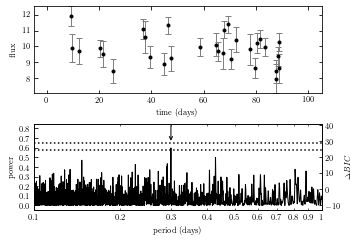

In [41]:
import numpy as np
from matplotlib import pyplot as plt
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Generate Data
np.random.seed(0)
N = 30
P = 0.3

t = np.random.randint(100, size=N) + 0.3 + 0.4 * np.random.random(N)
y = 10 + np.sin(2*np.pi * t / P)
dy = 0.5 + 0.5 * np.random.random(N)
y_obs = np.random.normal(y, dy)

# Compute periodogram
period = 10 ** np.linspace(-1, 0, 10000)
omega = 2 * np.pi / period
PS = lomb_scargle(t, y_obs, dy, omega, generalized=True)

# get significance via bootstrap
D = lomb_scargle_bootstrap(t, y_obs, dy, omega, generalized = True,
                          N_bootstraps=1000, random_state=0)
sig1, sig5 = np.percentile(D, [99, 95])

# Get significance via bootstrap
D = lomb_scargle_bootstrap(t, y_obs, dy, omega, generalized=True,
                          N_bootstraps=1000, random_state=0)
sig1, sig5 = np.percentile(D, [99, 95])

# Plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(left=0.1, right=0.9, hspace=0.35)

# First panel: the data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1, ecolor='gray')
ax.set_xlabel('time (days)')
ax.set_ylabel('flux')
ax.set_xlim(-5, 105)

# Second panel: the periodogram & significance levels
ax1 = fig.add_subplot(212, xscale='log')
ax1.plot(period, PS, '-', c='black', lw=1, zorder=1)
ax1.plot([period[0], period[-1]], [sig1, sig1], ':', c='black')
ax1.plot([period[0], period[-1]], [sig5, sig5], ':', c='black')

ax1.annotate("", (0.3, 0.65), (0.3, 0.85), ha='center',
             arrowprops=dict(arrowstyle='->'))

ax1.set_xlim(period[0], period[-1])
ax1.set_ylim(-0.05, 0.85)

ax1.set_xlabel(r'period (days)')
ax1.set_ylabel('power')

# Twin axis: label BIC on the right side
ax2 = ax1.twinx()
ax2.set_ylim(tuple(lomb_scargle_BIC(ax1.get_ylim(), y_obs, dy)))
ax2.set_ylabel(r'$\Delta BIC$')

ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_major_locator(plt.LogLocator(10))
ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3g'))

plt.show()

### Phased LINEAR Light Curve

@pickle_results: using precomputed results from 'LINEAR_LS.pkl'
 - omega_0 = 17.21695506
 - omega_0 = 51.10600808
 - omega_0 = 10.20062676
 - omega_0 = 45.55493503
 - omega_0 = 58.44512277
 - omega_0 = 10.82722772


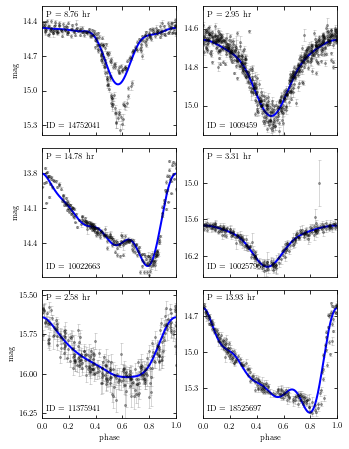

In [43]:
from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from astroML.utils.decorators import pickle_results
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit
from astroML.datasets import fetch_LINEAR_sample


if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
import matplotlib
matplotlib.rc('_internal', classic_mode=True)

# Load the dataset
data = fetch_LINEAR_sample()
ids = [14752041, 1009459, 10022663, 10025796, 11375941, 18525697]

# compute the best frequencies
@pickle_results('LINEAR_LS.pkl')
def compute_best_frequencies(ids, n_eval=10000, n_retry=5, generalized=True):
    results={}
    for i in ids:
        t, y, dy = data[i].T
        print("-computing power for {0} ({1} points)".format(i, len(t)))
        kwargs = dict(generalized=generalized)
        omega, power = search_frequencies(t, y, dy, n_eval=n_eval,
                                         n_retry=n_retry,
                                         LS_kwargs = kwargs)
        results[i] = [omega, power]
        
    return results

results = compute_best_frequencies(ids, n_eval = 10000, n_retry=5)

# Plot the phased light-curves
fig = plt.figure(figsize=(5, 6.5))
fig.subplots_adjust(hspace=0.1, bottom=0.06, top=0.94, left=0.12, right=0.94)

for i in range(6):
    # get the data and best-fit angular frequency
    t, y, dy = data[ids[i]].T
    omega, power = results[ids[i]]
    omega_best = omega[np.argmax(power)]
    print(" - omega_0 = %.10g" % omega_best)

    # do a fit to the first 4 Fourier components
    mtf = MultiTermFit(omega_best, 4)
    mtf.fit(t, y, dy)
    phase_fit, y_fit, phased_t = mtf.predict(1000, return_phased_times=True)

    # plot the phased data and best-fit curves
    ax = fig.add_subplot(321 + i)
    ax.errorbar(phased_t, y, dy, fmt='.k', ecolor='gray',
                lw=1, ms=4, capsize=1.5, alpha=0.3)
    ax.plot(phase_fit, y_fit, 'b', markeredgecolor='b', lw=2, fillstyle='top', linestyle='solid')

    ax.set_xlim(0, 1)
    ax.set_ylim(plt.ylim()[::-1])
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    ax.text(0.03, 0.04, "ID = %i" % ids[i], ha='left', va='bottom',
            transform=ax.transAxes)
    ax.text(0.03, 0.96, "P = %.2f hr" % (2 * np.pi / omega_best * 24.),
            ha='left', va='top',
            transform=ax.transAxes)

    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))

    if i < 4:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    if i % 2 == 0:
        ax.set_ylabel('mag')

    if i in (4, 5):
        ax.set_xlabel('phase')

plt.show()

### Lomb_Scargle Aliasing

        Use astropy.stats.LombScargle instead. [__main__]


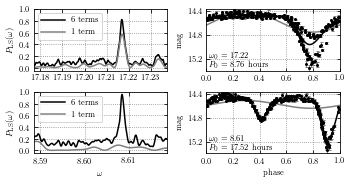

In [44]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from astroML.time_series import multiterm_periodogram, MultiTermFit
from astroML.datasets import fetch_LINEAR_sample

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
matplotlib.rcParams['axes.xmargin'] = 0

# Get data
data = fetch_LINEAR_sample()
t, y, dy = data[14752041].T

# Do a single-term and muti-term fit around the peak
omega0 = 17.217
nterms_fit = 6

# hack to get better phases: this doesn't change results
t -= 0.4 * np.pi / omega0

width = 0.03
omega = np.linspace(omega0 - width - 0.01, omega0 + width - 0.01, 1000)

# Compute periodograms and best - fit solutions
factors = [1, 2]
nterms = [1, 6]

# Compute PSDs for factors & nterms
PSDs = dict()
for f in factors: 
    for n in nterms:
        PSDs[(f, n)] = multiterm_periodogram(t, y, dy, omega / f, n)
        
# Compute the best-fit omega from the 6-term fit
omega_best = dict()
for f in factors:
    omegaf = omega / f
    PSDf = PSDs[(f, 6)]
    omega_best[f] = omegaf[np.argmax(PSDf)]
    
# Compute the best-fit solution based on the fundamental frequency
best_fit = dict()
for f in factors:
    for n in nterms:
        mtf = MultiTermFit(omega_best[f], n)
        mtf.fit(t, y, dy)
        phase_best, y_best = mtf.predict(1000, adjust_offset = False)
        
        best_fit[(f, n)] = (phase_best, y_best)
        
# Plot the results
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.95, hspace=0.35)

for i, f in enumerate(factors):
    P_best = 2 * np.pi / omega_best[f]
    phase_best = (t / P_best) % 1

    # first column: plot the PSD
    ax1 = fig.add_subplot(221 + 2 * i)
    ax1.plot(omega / f, PSDs[(f, 6)], '-', c='black', label='6 terms')
    ax1.plot(omega / f, PSDs[(f, 1)], '-', c='gray', label='1 term')
    ax1.grid(color='gray')
    ax1.legend(loc=2)

    ax1.axis('tight')

    ax1.set_ylim(-0.05, 1.001)
    ax1.xaxis.set_major_locator(plt.MultipleLocator(0.01))
    ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

    # second column: plot the phased data & fit
    ax2 = fig.add_subplot(222 + 2 * i)
    ax2.errorbar(phase_best, y, dy, fmt='.k', ms=4, ecolor='gray', lw=1,
                 capsize=1.5)
    ax2.plot(best_fit[(f, 1)][0], best_fit[(f, 1)][1], '-', c='gray')
    ax2.plot(best_fit[(f, 6)][0], best_fit[(f, 6)][1], '-', c='black')

    ax2.text(0.02, 0.02, (r"$\omega_0 = %.2f$" % omega_best[f] + "\n"
                          + r"$P_0 = %.2f\ {\rm hours}$" % (24 * P_best)),
             ha='left', va='bottom', transform=ax2.transAxes)

    ax2.grid(color='gray')
    ax2.set_xlim(0, 1)
    ax2.set_ylim(plt.ylim()[::-1])
    ax2.yaxis.set_major_locator(plt.MultipleLocator(0.4))

    # label both axes
    ax1.set_ylabel(r'$P_{\rm LS}(\omega)$')
    ax2.set_ylabel(r'${\rm mag}$')
    if i == 1:
        ax1.set_xlabel(r'$\omega$')
        ax2.set_xlabel(r'${\rm phase}$')

plt.show()

        Use astropy.stats.LombScargle instead. [__main__]


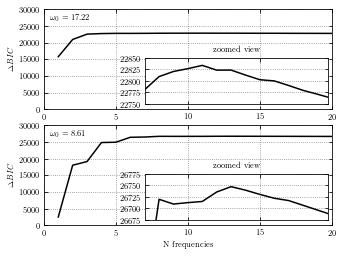

In [45]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.time_series import multiterm_periodogram, lomb_scargle_BIC
from astroML.datasets import fetch_LINEAR_sample


if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


# Fetch the data
data = fetch_LINEAR_sample()

t, y, dy = data[14752041].T
omega0 = 17.217

# focus only on the region with the peak
omega1 = np.linspace(17.213, 17.220, 100)
omega2 = 0.5 * omega1

# Compute the delta BIC
terms = np.arange(1, 21)
BIC_max = np.zeros((2, len(terms)))

for i, omega in enumerate([omega1, omega2]):
    for j in range(len(terms)):
        P = multiterm_periodogram(t, y, dy, omega, terms[j])
        BIC = lomb_scargle_BIC(P, y, dy, n_harmonics = terms[j])
        BIC_max[i, j] = BIC.max()
        
# Plot the results
fig = plt.figure(figsize=(5, 3.75))

ax = [fig.add_axes((0.15, 0.53, 0.8, 0.37)),
      fig.add_axes((0.15, 0.1, 0.8, 0.37))]
ax_inset = [fig.add_axes((0.15 + 7 * 0.04, 0.55, 0.79 - 7 * 0.04, 0.17)),
            fig.add_axes((0.15 + 7 * 0.04, 0.12, 0.79 - 7 * 0.04, 0.17))]
ylims = [(22750, 22850),
         (26675, 26775)]
omega0 = [17.22, 8.61]

for i in range(2):
    # Plot full panel
    ax[i].plot(terms, BIC_max[i], '-k')
    ax[i].set_xlim(0, 20)
    ax[i].set_ylim(0, 30000)
    ax[i].text(0.02, 0.95, r"$\omega_0 = %.2f$" % omega0[i],
               ha='left', va='top', transform=ax[i].transAxes)

    ax[i].set_ylabel(r'$\Delta BIC$')
    if i == 1:
        ax[i].set_xlabel('N frequencies')
    ax[i].grid(color='gray')

    # plot inset
    ax_inset[i].plot(terms, BIC_max[i], '-k')
    ax_inset[i].xaxis.set_major_locator(plt.MultipleLocator(5))
    ax_inset[i].xaxis.set_major_formatter(plt.NullFormatter())
    ax_inset[i].yaxis.set_major_locator(plt.MultipleLocator(25))
    ax_inset[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
    ax_inset[i].set_xlim(7, 19.75)
    ax_inset[i].set_ylim(ylims[i])
    ax_inset[i].set_title('zoomed view')
    ax_inset[i].grid(color='gray')

plt.show()

### Arrival Time Analysis

Number of observed photons: 104
@pickle_results: computing results and saving to 'arrival_times.pkl'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_omega, phi, a, r0]
Sampling 4 chains: 100%|██████████| 28000/28000 [01:33<00:00, 300.88draws/s]


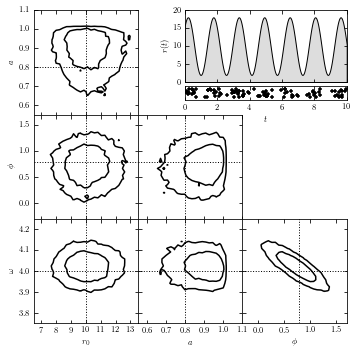

In [2]:

from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

import pymc3 as pm

from astroML.plotting.mcmc import plot_mcmc
from astroML.utils.decorators import pickle_results

# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# ------------------------------------------------------------
# Create  some  data
np.random.seed(1)
N_expected = 100


# define our rate function
def rate_func(t, r0, a, omega, phi):
    return r0 * (1 + a * np.sin(omega * t + phi))


# define the time steps
t = np.linspace(0, 10, 10000)
Dt = t[1] - t[0]

# compute the total rate in each bin
r0_true = N_expected / (t[-1] - t[0])
a_true = 0.8
phi_true = np.pi / 4
omega_true = 4
r = rate_func(t, r0_true, a_true, omega_true, phi_true)

# randomly sample photon arrivals from the rate
x = np.random.random(t.shape)
obs = (x < r * Dt).astype(int)
print("Number of observed photons:", np.sum(obs))


# ----------------------------------------------------------------------
# We need to wrap it in a function in order to be able to pickle the result
@pickle_results('arrival_times.pkl')
def compute_model(draws=5000, tune=2000):
    # Set up and run our MCMC model
    with pm.Model():
        r0 = pm.Uniform('r0', 0, 1000)
        a = pm.Uniform('a', 0, 1)
        phi = pm.Uniform('phi', -np.pi, np.pi)
        log_omega = pm.Uniform('log_omega', 0, np.log(10))

        y = pm.Poisson('y', mu=rate_func(t, r0, a, np.exp(log_omega), phi) * Dt,
                       observed=obs)

        traces = pm.sample(draws=draws, tune=tune)
        return traces


traces = compute_model()

labels = ['$r_0$', '$a$', r'$\phi$', r'$\omega$']
limits = [(6.5, 13.5), (0.55, 1.1), (-0.3, 1.7), (3.75, 4.25)]
true = [r0_true, a_true, phi_true, omega_true]

# ------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))

# This function plots multiple panels with the traces
plot_mcmc([traces[i] for i in ['r0', 'a', 'phi']] + [np.exp(traces['log_omega'])],
          labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, colors='k')

# Plot the model of arrival times
ax = fig.add_axes([0.5, 0.75, 0.45, 0.2])
ax.fill_between(t, 0, rate_func(t, r0_true, a_true, omega_true, phi_true),
                facecolor='#DDDDDD', edgecolor='black')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_xlim(t[0], t[-1])
ax.set_ylim(0, 20)
ax.set_ylabel('$r(t)$')

# Plot the actual data
ax = fig.add_axes([0.5, 0.7, 0.45, 0.04], yticks=[])
t_obs = t[obs > 0]
ax.scatter(t_obs, np.random.RandomState(0).rand(len(t_obs)),
           marker='+', color='k')
ax.set_xlim(t[0], t[-1])
ax.set_ylim(-0.3, 1.3)
ax.set_xlabel('$t$')
plt.show()


### Chirp Wavelet PSD

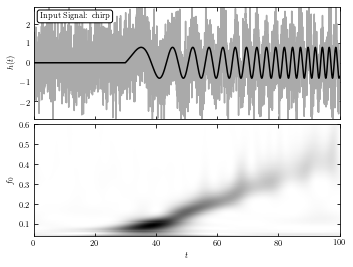

In [53]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.fourier import FT_continuous, IFT_continuous, wavelet_PSD

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


#------------------------------------------------------------
# Define the chirp signal
def chirp(t, T, A, phi, omega, beta):
    signal = A * np.sin(phi + omega * (t - T) + beta * (t - T) ** 2)
    signal[t < T] = 0
    return signal


def background(t, b0, b1, Omega1, Omega2):
    return b0 + b1 * np.sin(Omega1 * t) * np.sin(Omega2 * t)

np.random.seed(42)
N = 4096
t = np.linspace(-50, 50, N)
h_true = chirp(t, -20, 0.8, 0, 0.2, 0.02)
h = h_true + np.random.normal(0, 1, N)

#------------------------------------------------------------
# Compute the wavelet PSD
f0 = np.linspace(0.04, 0.6, 100)
wPSD = wavelet_PSD(t, h, f0, Q=1.0)

#------------------------------------------------------------
# Plot the  results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(hspace=0.05, left=0.1, right=0.95, bottom=0.1, top=0.95)

# Top: plot the data
ax = fig.add_subplot(211)
ax.plot(t + 50, h, '-', c='#AAAAAA')
ax.plot(t + 50, h_true, '-k')

ax.text(0.02, 0.95, "Input Signal: chirp",
        ha='left', va='top', transform=ax.transAxes,
        bbox=dict(boxstyle='round', fc='w', ec='k'))

ax.set_xlim(0, 100)
ax.set_ylim(-2.9, 2.9)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('$h(t)$')

# Bottom: plot the 2D PSD
ax = fig.add_subplot(212)
ax.imshow(wPSD, origin='lower', aspect='auto',
          extent=[t[0] + 50, t[-1] + 50, f0[0], f0[-1]],
          cmap=plt.cm.binary)

ax.text(0.02, 0.95, ("Wavelet PSD"), color='w',
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlim(0, 100)
ax.set_ylim(0.04, 0.6001)
ax.set_xlabel('$t$')
ax.set_ylabel('$f_0$')

plt.show()

### Generating Power Law Light Curves

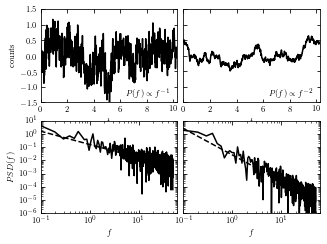

In [54]:
import numpy as np
from matplotlib import pyplot as plt
from astroML.time_series import generate_power_law
from astroML.fourier import PSD_continuous

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

N = 1024
dt = 0.01
factor = 100

t = dt * np.arange(N)
random_state = np.random.RandomState(1)

fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(wspace=0.05)

for i, beta in enumerate([1.0, 2.0]):
    # Generate the light curve and compute the PSD
    x = factor * generate_power_law(N, dt, beta, random_state=random_state)
    f, PSD = PSD_continuous(t, x)

    # First axes: plot the time series
    ax1 = fig.add_subplot(221 + i)
    ax1.plot(t, x, '-k')

    ax1.text(0.95, 0.05, r"$P(f) \propto f^{-%i}$" % beta,
             ha='right', va='bottom', transform=ax1.transAxes)

    ax1.set_xlim(0, 10.24)
    ax1.set_ylim(-1.5, 1.5)

    ax1.set_xlabel(r'$t$')

    # Second axes: plot the PSD
    ax2 = fig.add_subplot(223 + i, xscale='log', yscale='log')
    ax2.plot(f, PSD, '-k')
    ax2.plot(f[1:], (factor * dt) ** 2 * (2 * np.pi * f[1:]) ** -beta, '--k')

    ax2.set_xlim(1E-1, 60)
    ax2.set_ylim(1E-6, 1E1)

    ax2.set_xlabel(r'$f$')

    if i == 1:
        ax1.yaxis.set_major_formatter(plt.NullFormatter())
        ax2.yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax1.set_ylabel(r'${\rm counts}$')
        ax2.set_ylabel(r'$PSD(f)$')

plt.show()

### Autocorrelation Function

        Use astropy.stats.LombScargle instead. [astroML.time_series.ACF]
        Use astropy.stats.LombScargle instead. [astroML.time_series.ACF]


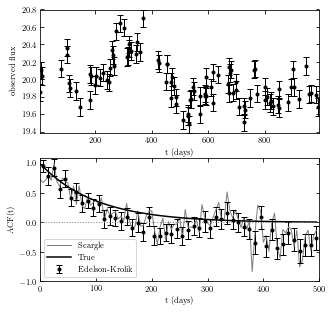

In [55]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.time_series import lomb_scargle, generate_damped_RW
from astroML.time_series import ACF_scargle, ACF_EK

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Generate time-series data:
#  we'll do 1000 days worth of magnitudes

t = np.arange(0, 1E3)
z = 2.0
tau = 300
tau_obs = tau / (1. + z)

np.random.seed(6)
y = generate_damped_RW(t, tau=tau, z=z, xmean=20)

# randomly sample 100 of these
ind = np.arange(len(t))
np.random.shuffle(ind)
ind = ind[:100]
ind.sort()
t = t[ind]
y = y[ind]

# add errors
dy = 0.1
y_obs = np.random.normal(y, dy)

# compute ACF vis scargle method
C_S, t_S = ACF_scargle(t, y_obs, dy, 
                      n_omega=2. ** 12, omega_max = np.pi / 5.0)

ind = (t_S >= 0) & (t_S <= 500)
t_S = t_S[ind]
C_S = C_S[ind]

# compute ACF via E-K method
C_EK, C_EK_err, bins = ACF_EK(t, y_obs, dy, bins = np.linspace(0, 500, 51))
t_EK = 0.5 * (bins[1:] + bins[:-1])

# Plot the results
fig = plt.figure(figsize=(5, 5))

# plot the input data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1)
ax.set_xlabel('t (days)')
ax.set_ylabel('observed flux')

# plot the ACF
ax = fig.add_subplot(212)
ax.plot(t_S, C_S, '-', c='gray', lw=1,
        label='Scargle')
ax.errorbar(t_EK, C_EK, C_EK_err, fmt='.k', lw=1,
            label='Edelson-Krolik')
ax.plot(t_S, np.exp(-abs(t_S) / tau_obs), '-k', label='True')
ax.legend(loc=3)

ax.plot(t_S, 0 * t_S, ':', lw=1, c='gray')

ax.set_xlim(0, 500)
ax.set_ylim(-1.0, 1.1)

ax.set_xlabel('t (days)')
ax.set_ylabel('ACF(t)')

plt.show()